# 2 - Building and using matrices

In [7]:
import bw_processing as bwp
import matrix_utils as mu
import bw2calc as bc
import numpy as np
import seaborn as sb
import pandas as pd

Before we dive into it, let's think about what we need to actually build a matrix. What specific data would you need? What don't you need?

## Exercise

Please think about the minimal set of information you would need to build a *sparse matrix* using [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (sparse matrices store only non-zero values). Then, create this information as Numpy arrays and actually build a sparse matrix.

Here is the matrix you should build:

$$\begin{bmatrix} 0 & 1 \\ 2 & 3 \end{bmatrix}$$

## Hint

You will need three Numpy arrays: one for the data, one for the row indices, and one for the column indices.

## Solution

In [8]:
from scipy import sparse

data = np.array([1, 2, 3])
rows = np.array([0, 1, 1])
cols = np.array([1, 0, 1])

matrix = sparse.coo_matrix((data, (rows, cols)), (2, 2))
matrix.toarray()

array([[0, 1],
       [2, 3]])

## `bw_processing`

We can run into difficulties when we want to store this data. The library `bw_processing` helps us create data packages, which can store this matrix-building data on variety of file systems. You can read the [`bw_processing` README](github.com/brightway-lca/bw_processing) for more information, and can see the [PyFilesystem2 Docs](https://docs.pyfilesystem.org/en/latest/) for more on the filesystems that can be used.

Let's define this same matrix in `bw_processing`.

Matrices by definition are two-dimensional, so we know that to build matrices we will always need to specify the row and column indices of the data. We combine these two arrays into a single Numpy [structured array](https://numpy.org/doc/stable/user/basics.rec.html), which uses the labels `row` and `col`.

In [9]:
import bw_processing as bwp
import numpy as np

indices_array = np.array([(0, 1), (1, 0), (1, 1)], dtype=bwp.INDICES_DTYPE)
indices_array

array([(0, 1), (1, 0), (1, 1)], dtype=[('row', '<i4'), ('col', '<i4')])

In [10]:
indices_array['row']

array([0, 1, 1], dtype=int32)

In [11]:
bwp.INDICES_DTYPE

[('row', numpy.int32), ('col', numpy.int32)]

The data array is the same as before:

In [12]:
data_array = np.array([1, 2, 3])
data_array

array([1, 2, 3])

This is all we need to create a data package:

In [13]:
dp = bwp.create_datapackage()

dp.add_persistent_vector(
    matrix="some name",
    data_array=data_array,
    name="some name",
    indices_array=indices_array,
)

For such simple matrices, we can also use a shortcut:

In [14]:
bwp.simple_graph({
    "some name": [
        (0, 1, 1),
        (1, 1, 2),
        (1, 1, 3),
    ]
})

But before this gets too abstract, let's do the same for our example system:

<img src='images/simple-graph.png' width='400'>

We need integer indices for each concept. The numbers themselves are arbitrary, the point is that we will use them consistently in the datapackages, and maintain a mapping from our concepts to these numbers. This might be similar to other fundamental concepts such as a [basis](https://en.wikipedia.org/wiki/Basis_(linear_algebra)).

In [15]:
natural_gas = 101
carbon_fibre = 102
bike = 103
co2 = 201

In our technosphere matrix, we will have three production exchanges (each of amount 1), and two consumption exchanges. Our biosphere matrix will only have one number, the emission of $CO_{2}$ from carbon fibre production.

Our matrices should look like this:

## Technosphere matrix

Dimensions are products (rows) by activities (columns).

$$
\left[\begin{array}{ccc} 
1 & 0 & 0\\
-237 & 1 & 0\\
0 & -2.5 & 1\\
\end{array}\right]
$$

## Biosphere matrix

Dimensions are flows (rows) by activities (columns).

$$
\left[\begin{array}{ccc} 
0 & 26.6 & 0\\ 
\end{array}\right]
$$ 

## Characterization matrix

Dimensions are flows (rows) by flows (columns).

$$
\left[\begin{array}{c} 
1\\ 
\end{array}\right]
$$

# A first LCA calculation

To use datapackages, we need to know four thing for each point: the row and column ids, the data value, and the sign. We only need to store the non-zero points. Here is an example for the technosphere matrix:

In [16]:
t_data = np.array([
    1,   # production of natural gas
    1,   # production of carbon fibre
    1,   # production of bike
    237, # input of natural gas
    2.5, # input of carbon fibre
])
t_indices = np.array([
    (101, 101), # production of natural gas
    (102, 102), # production of carbon fibre
    (103, 103), # production of bike
    (101, 102), # input of natural gas
    (102, 103), # input of carbon fibre
    ], 
    dtype=bwp.INDICES_DTYPE
)
t_flip = np.array([False, False, False, True, True]) # Numerical sign of the inputs needs to be flipped negative

And similarly for the other matrices (no need to flip signs, so we skip that part):

In [17]:
b_data = np.array([26.6])
b_indices = np.array([
    (201, 102), # emission of CO2
    ], 
    dtype=bwp.INDICES_DTYPE
)

In [18]:
c_data = np.array([1])
c_indices = np.array([
    (201, 201), # CF of CO2
    ], 
    dtype=bwp.INDICES_DTYPE
)

We can now create our datapackage, and add the data for all three matrices to it:

In [19]:
dp_static = bwp.create_datapackage()

In [20]:
dp_static.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
)
dp_static.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
)
dp_static.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

This is already enough to calculate an LCA score:

In [21]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static],
)
lca.lci()
lca.lcia()
lca.score

66.50000000000001

## Exercise

Do the same for your steel bike. Make sure you get the same LCIA results as before.

# A stochastic LCA

This is pretty boring so far. The only marginally interesting thing is that we could put our datapackage on another computer, and do calculations on that computer - i.e. we are ready for cloud calculations. Indeed, the library `matrix_utils` allows us to specify datapackages on FTP sites and cloud storage such as Amazon S3.

But we can make our example more interesting by adding uncertainty. To do this, we will use the standards in the [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) library.

We will only add uncertainty to the inputs, and the CO2 emission. The other edges will have uncertainty type zero - no uncertainty.

In [22]:
t_uncertainty = np.array([
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),    
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),    
        (5, 237, np.NaN, np.NaN, 200, 300, False), # triangular uncertainty from 200 to 300  
        (5, 2.5, np.NaN, np.NaN, 2, 3, False), # triangular uncertainty from 2 to 3
    ], 
    dtype=bwp.UNCERTAINTY_DTYPE
)
b_uncertainty = np.array([
        (3, 26.6, 1.5, np.NaN, np.NaN, np.NaN, False), # normal uncertainty with std. dev. of 1.5
    ], 
    dtype=bwp.UNCERTAINTY_DTYPE
)

We then will create another data package, and use it to do Monte Carlo:

In [23]:
dp_stochastic = bwp.create_datapackage()

In [24]:
dp_stochastic.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
    distributions_array=t_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
    distributions_array=b_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

In [25]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic],
    use_distributions=True,
)
lca.lci()
lca.lcia()
    
mc_results = [lca.score for _ in zip(range(50), lca)]

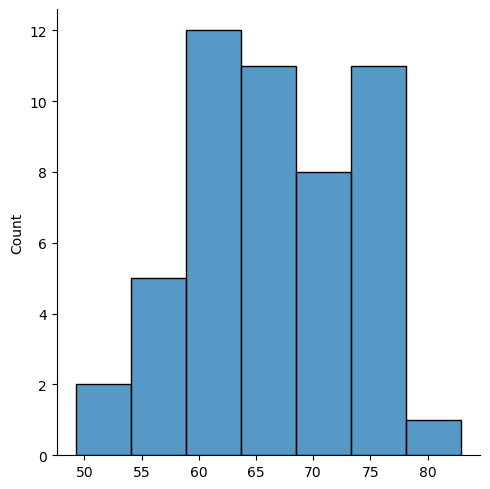

In [26]:
sb.displot(np.array(mc_results))

In [27]:
import numpy as np

## Class Exercise

The numpy function for correlation coefficients is `corrcoef`. Can we do a basic sensitivity analysis on the Monte Carlo parameters? See if you can capture the matrix values during each iteration, and then calculate the correlation coefficients between this matrix values and the LCIA scores.

# Correlating exchanges

If we sample each exchange independently, we lose some of the logic of our product system. In our example system, the $CO_{2}$ should be tied directly to the natural gas consumption, but it isn't:

In [28]:
params = []

for _ in range(100):
    next(lca)
    params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

<Axes: xlabel='ng', ylabel='co2'>

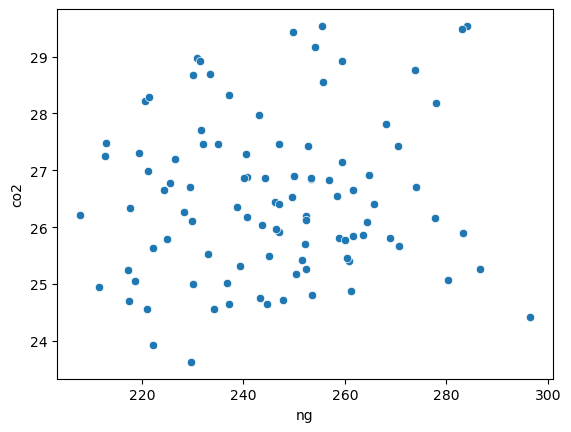

In [29]:
sb.scatterplot(data=pd.DataFrame(params), x='ng', y='co2')

We fix this by drawing correlated samples ahead of time - this is the idea behind the `presamples` package, whose functionality is now integrated directly into Brightway. We will make up a model to illustrate how this would work; we can assume that (again, totally made up) 80% of the natural gas goes to energy, the ratio stays the same, but with a little bit of noise.

In [ ]:
ng_samples = np.random.triangular(200, 237, 300, size=100)
co2_samples = 26.6 / 237 * ng_samples * np.random.normal(loc=1, scale=0.025, size=100)

We can now add another datapackage which will overwrite our previous values (but only where we tell it to). Note that we are now creating `arrays`, not `vectors`.

We need to tell the datapackage that these two resources are correlated - otherwise there would be two RNGs used to samples them independently again. We can do this by either setting `sequential=True` (in which case they would start with column 0, then column 1, etc.), or by using the same RNG seed for both resources.

In [ ]:
dp_correlated = bwp.create_datapackage(seed=42)

In [ ]:
dp_correlated.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(101, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=ng_samples.reshape((1, -1)),
    flip_array=np.array([True]) ,
)
dp_correlated.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=np.array([(201, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=co2_samples.reshape((1, -1)),
)

And now the use of our correlated samples reflects reality a lot better. Note that we justs add the new datapackage after the original one, and set `use_arrays=True`:

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic, dp_correlated],
    use_distributions=True,
    use_arrays=True,
)
lca.lci()
lca.lcia()

corr_params = []

for _ in range(100):
    next(lca)
    corr_params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

In [ ]:
sb.scatterplot(data=pd.DataFrame(corr_params), x='ng', y='co2')

## Exercise

Do the same for your steel bike - correlate iron ore resource consumption to mining.

# Using arrays for scenarios

In addition to correlated samples, we can use arrays for scenarios. Let's imagine two different possibilities: a lightweight bike with 1.5 kilograms of carbon fibre, and a technology platform that allows for efficient bike sharing making each bike functionally equivalent to two bikes (I know, I find this silly as well). If we treat these as separate possibilities, we have four scenarios in total.

For this to work, we will need to create **two** new arrays, one for each choice, and then tell the software to do combinatorial sampling:

In [ ]:
dp_scenarios = bwp.create_datapackage(combinatorial=True)

In [ ]:
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(102, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(2.5, 1.5)]),
    flip_array=np.array([True]),
    name='cf scenario'
)
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(103, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(1, 2)]),
    name='double bike'
)

In [ ]:
scenario_mapping = {
    (0, 0): "Original",
    (0, 1): "Each bike counts double",
    (1, 0): "Lightweight",
    (1, 1): "Lightweight & each bike counts double",
}

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, dp_scenarios],
    use_arrays=True,
)
lca.lci()
lca.lcia()

In [ ]:
resource_group = next(grp for grp in lca.technosphere_mm.groups if grp.label == 'double bike').indexer.indexer

In [ ]:
print(lca.score, scenario_mapping[resource_group.index])

for scenario_result in lca:
    print(lca.score, scenario_mapping[resource_group.index])

## Exercise

Can you build a half steel, half carbon fiber bike? Can you construct scenarios to vary the percentages (say, three scenarios)?

# Interfaces

We can add some electricity consumption to the bike manufacturing process, and demonstrate how an `Interface` should work. For our example interface, we can use the Danish company Energinet's [API for the 5 minute interval CO2 intensity of Danish electricity](https://www.energidataservice.dk/tso-electricity/co2emis):

In [ ]:
import requests

class DenmarkCO2Interface:
    size = (1,)

    def __next__(self):
        # Supposed to work with ISO 8601 but T intervals raise error...
        URL = "https://api.energidataservice.dk/dataset/co2emis?start=now-P1D&end=now"
        print("Querying energidataservice.dk API")
        result = requests.get(URL).json()['records'][0]['CO2Emission']
        return np.array([result]) / 1000 # g to kg

That was just the CO2 intensity, we also need to add a node for electricity consumption. We will give it the ID `104`, and use 100 kilowatt hours (way too high, I know).

In [ ]:
dk_elec_dp = bwp.create_datapackage()

In [ ]:
dk_elec_dp.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=np.array([
            (104, 104), # production of electricity
            (104, 103), # use of electricity in bike production
        ], 
        dtype=bwp.INDICES_DTYPE
    ),
    data_array=np.array([1, 100]),
    flip_array=np.array([False, True]),
)

We can now add our interface. We are not adding `persistent` data, but `dynamic` data:

In [ ]:
dk_elec_dp.add_dynamic_vector(
    matrix='biosphere_matrix',
    interface=DenmarkCO2Interface(),
    indices_array=np.array([(201, 104)], dtype=bwp.INDICES_DTYPE),
)

As before, we can just add the data packages together:

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, dk_elec_dp],
)
lca.lci()
lca.lcia()
lca.score

This is the value we got for CO2 intensity (in kg CO2-eq/kwh):

In [ ]:
lca.biosphere_matrix[0, lca.dicts.activity[104]]

Other countries also have similar APIs, for example France:

<div class="alert alert-block alert-warning">
    The Interface below includes a parameter <code>verify=False</code> in the call to the <code>requests</code> library to pull the data.
    
    
The TLS configuration from www.rte-france.com is incomplete, but the certificates are valid. You can verify the validity by pointing your browser to the <a href="https://www.rte-france.com/themes/swi/xml/power-co2-emission-fr.xml"> API URL</a> <strong>. 
    We can safely use requests with: </strong> <code>"verify=False"</code>, but the <code>requests</code> library will still warn us about this.
    
More details on this at https://github.com/Depart-de-Sentier/try_brightway_dev/issues/3

</div>

In [ ]:
from time import time
import xml.etree.ElementTree as ET

class FranceCO2Interface:
    size = (1,)
    
    def __next__(self):
        # Note: has timestamp but seems to always give latest data
        URL_TEMPLATE = "https://www.rte-france.com/themes/swi/xml/power-co2-emission-fr.xml?_={}"
        print("Querying RTE Eco2mix interface")
        URL = URL_TEMPLATE.format(int(time()))
        # the TLS configuration from www.rte-france.com is incomplete, but the certificates are valid.
        # To verify the validity, point your browser to the URL
        # so, we can safely use requests with "verify=False"
        # see issue on the repo of this notebook -> https://github.com/Depart-de-Sentier/try_brightway_dev/issues/3
        # requests will still warn us about this.
        resp = requests.get(URL, verify=False)        
        root = ET.fromstring(resp.text)
        return np.array([[float(child.text) for child in root.iter('valeur')][-1]]) / 1000 # g to kg

In [ ]:
fr_elec_dp = bwp.create_datapackage()

fr_elec_dp.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=np.array([
            (104, 104), # production of electricity
            (104, 103), # use of electricity in bike production
        ], 
        dtype=bwp.INDICES_DTYPE
    ),
    data_array=np.array([1, 100]),
    flip_array=np.array([False, True]),
)

fr_elec_dp.add_dynamic_vector(
    matrix='biosphere_matrix',
    interface=FranceCO2Interface(),
    indices_array=np.array([(201, 104)], dtype=bwp.INDICES_DTYPE),
)

As before, we can just add the data packages together:

In [ ]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, fr_elec_dp],
)
lca.lci()
lca.lcia()
lca.score

This is the value we got for CO2 intensity (in kg CO2-eq/kwh):

In [ ]:
lca.biosphere_matrix[0, lca.dicts.activity[104]]

## Class Exercise

How would we model a system where we could choose between Danish and French electricity as two scenarios?